<h1 style="font-size:60px;">LEMME ATTEM</h1>

Lemme Attem aims to train an L-layer neural network to recognize pictures of the League of Legends champion Fizz. The algorithm will be of the following structure:

Forward propagation: (LINEAR -> RELU) * (L-1) -> LINEAR -> SIGMOID

Backward propagation: LINEAR -> SIGMOID -> (LINEAR -> RELU) * (L-1) (Gradient descent)

<h1>Packages</h1>

- <a href="https://numpy.org/">numpy</a>: fundamental package for scientific computing with Python
- <a href="https://matplotlib.org/">matplotlib</a>: a library to plot grapsh in Python
- <a href="http://www.h5py.org/">h5py</a>: a common package to interact with a dataset that is stored on an H5 file
- <a href="http://www.pythonware.com/products/pil/">PIL</a>, <a href="https://www.scipy.org/">SciPy</a>, and <a href="https://pypi.org/project/imageio/">imageio</a>: used here to format data and to test the model with individual pictures
- utils: provides functions implemented in the deep neural network

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import imageio
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

<h1>Dataset</h1>

Four pieces of data will be used to teach/test our network:
- train_x is the input data that we will use to train our network
- train_y is the output data that we expect from our network (1 = Fizz, 0 = not Fizz)
- test_x is the input data that we will use to test our network once it has learned the W and b parameters
- test_y is the output data that we expect from our network (1 = Fizz, 0 = not Fizz)

The fifth piece of data (classes) is for display purposes only.

In [2]:
num_px = 400

format_data("train", 200, num_px)
format_data("test", 50, num_px)
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The cell below allows you to preview images along with the image's desired output. Change the index variable to view different images.

y = 1. It's Fizz!


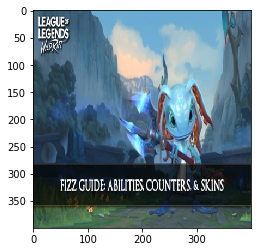

In [3]:
# Example of a picture
index = 45
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's " + classes[train_y[0,index]] + "!")

In [4]:
# Get to know your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: 200
Number of testing examples: 50
Each image is of size: (400, 400, 3)
train_x_orig shape: (200, 400, 400, 3)
train_y shape: (1, 200)
test_x_orig shape: (50, 400, 400, 3)
test_y shape: (1, 50)


Before feeding images to the network, we need to reshape the image to be of the following shape: (num_px * num_px * 3, 1), i.e. a column vector representing each pixel in each of the 3 RGB grids.

In [5]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to ahve feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (480000, 200)
test_x's shape: (480000, 50)


<h1>Architecture of our L-layer Deep Neural Network</h1>

Our deep neural network will consist of one input layer, L-1 hidden layers, and one output layer. Flow through the network will be as follows:

- The input layer will receive data in the form of our flattened image vectors, stacked horizontally next to one another.
- Each hidden layer will receive its input from the previous hidden layer. Input will then be multiplied by the layer's weight vector, ($W^{[l]}$), and added to the layer's bias vector, ($b^{[l]}$). The resultant vector will serve as input the the layer's activation function, ($a^{[l]}$). This process will be repeated several times until we reach the output layer.
    - Activation functions for all hidden layers except the output layer will be the ReLU function. The activation function for the output layer will be the sigmoid function.


<h2>General methodology</h2>

We will follow the Deep Learning methodology to build the model:
    1. Initialize parameters /  Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop)
    3. Use trained parameters to predict labels

In [6]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if not Fizz, 1 if Fizz), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1)
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iteration of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters)
        
        # Comput cost
        cost = compute_cost(AL, Y)
        
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

We will not train the model. Update layers_dims below to change the layout of the neural network.

In [7]:
n0 = num_px * num_px * 3

layers_dims = [n0, 100, 50, 20, 10, 5, 1]

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.692584
Cost after iteration 200: 0.692197
Cost after iteration 300: 0.691931
Cost after iteration 400: 0.691748
Cost after iteration 500: 0.691622
Cost after iteration 600: 0.691536
Cost after iteration 700: 0.691477
Cost after iteration 800: 0.691436
Cost after iteration 900: 0.691408
Cost after iteration 1000: 0.691389
Cost after iteration 1100: 0.691375
Cost after iteration 1200: 0.691366
Cost after iteration 1300: 0.691360
Cost after iteration 1400: 0.691356
Cost after iteration 1500: 0.691353
Cost after iteration 1600: 0.691351
Cost after iteration 1700: 0.691349
Cost after iteration 1800: 0.691348
Cost after iteration 1900: 0.691348
Cost after iteration 2000: 0.691347
Cost after iteration 2100: 0.691347
Cost after iteration 2200: 0.691347
Cost after iteration 2300: 0.691346
Cost after iteration 2400: 0.691346


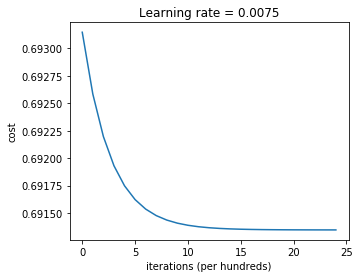

In [8]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [9]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.53


In [10]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.56


<h1>Results Analysis</h1>

**Accuracy when predicting the training set: 53%**

**Accuracy when predicting the test set: 56%**

We tested several iterations of the learning algorithm after making adjustments to various hyperparameters. We changed the number of pixels in each image, the number of hidden layers in the network, the number of neurons in each hidden layer, and the learning rate.

Each iteration of the neural network produced nearly the exact same results. This leads us to believe that regardless of the above hyperparameters and their values, the network learns the same functions, and those functions are not the ones that we are looking to learn.


<h2>Goals for the next network</h2>

Our goal with this network was to teach a network to recognize pictures of Fizz. Our goal for the next network needs to be more specific, and the training data must reflect the goal accurately. For example, a better goal may have been to recognize Fizz's splash art in the default skin.

In the future, it may be possible to identify pictures of Fizz in different skins and settings. However, the current architecture that we use is not optimal for this kind of learning.